<a href="https://colab.research.google.com/github/collma/Sistemas-dinamicos-y-redes-neuronales/blob/main/Clase_4_Redes_Regresion_Caos_Lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

# Regresión con Redes Neuronales


## 1) Generacion del Dataset: Flujo Caótico

Como primer paso, vamos a generar la serie temporal a partir de un sistema dinámico. Usaremos los códigos que ya venimos usando durtante la materia para hacerlo.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def ecuaciones(x, t):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''
    x, y, z = x[0], x[1], x[2] # los separe por las dudas

    x_dot = 10*(y - x)
    y_dot = x*(28-z)-y
    z_dot = x*y-8/3*z

    return x_dot, y_dot, z_dot

def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6

def integrar_ecuaciones(total_time,dt,X0):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''

    num_steps = int(np.divide(total_time,dt))
    # tmax = 1
    t = np.arange(0, total_time, dt) # Le meti este vector t donde tmax = total_time

    # Empty vectors
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)

    # Set initial values
    xs[0], ys[0], zs[0] = X0

    # Empty vectors
    x_dot = np.empty(num_steps)
    y_dot = np.empty(num_steps)
    z_dot = np.empty(num_steps)

    # Set initial derivatives values
    x_dot[0], y_dot[0], z_dot[0] = ecuaciones([xs[0], ys[0], zs[0]], t) # nos estaba faltando llamar a t en ecuaciones

 #   # Integramos con método de Euler
 #   for i in range(num_steps-1):
 #       x_dot[i], y_dot[i], z_dot[i] = ecuaciones(xs[i], ys[i], zs[i])
 #       xs[i + 1] = xs[i] + (x_dot[i] * dt)
 #       ys[i + 1] = ys[i] + (y_dot[i] * dt)
 #       zs[i + 1] = zs[i] + (z_dot[i] * dt)
   
    # Integramos con método de Runge-Kutta 4  
    for i in range(len(t) - 1):
      xs[i+1], ys[i+1], zs[i+1] = rk4(ecuaciones, [xs[i], ys[i], zs[i]], t, dt)

    return xs, ys, zs, num_steps

In [4]:
# Simulamos los datos
total_time = 1000
dt = 0.005
t = np.arange(0, 1, dt)
X0 = (10, 10, 0)

xs, ys, zs, num_steps = integrar_ecuaciones(total_time,dt,X0)
print('largo de xs:', xs.shape)
print('num_steps:', num_steps)

largo de xs: (200000,)
num_steps: 200000


Grafiquemos la solución del sistema.

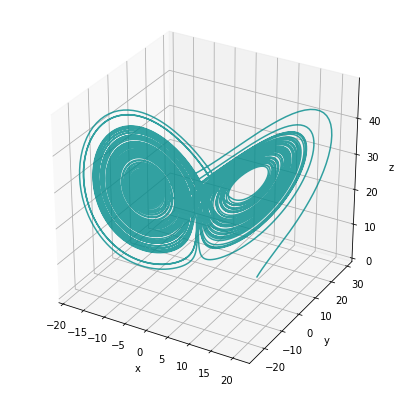

In [5]:
# Numero de puntos a graficar
N = 20000

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
ax.plot3D(xs[0:N],ys[0:N],zs[0:N], 'darkcyan', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Primero vamos a normalizar y subsamplear la a serie temporal.

In [6]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Subsampleo temporal de la señal
subsampleo = 100

#Maximo de la señal para normalizar
maximo = np.max(np.abs(xs))

# Separamos la serie en 2 partes, una para el train set y otra para el test set.
training_set_scaled = np.divide(xs[:indice_test:subsampleo],maximo)   #agarra desde el primer valor del vector xs, hasta el dato 0.75 (que empieza el indice test) y los divide por el maximo de xs para normlaizar
test_set_scaled = np.divide(xs[indice_test::subsampleo],maximo)


Ahora, armaremos el dataset a utilizar a partir de esta serie temporal. Entrenaremos la red de manera de que la entrada sean N pasos consecutivos de la serie y su objetivo sea predecir el siguiente paso. 

La cantidad de pasos para atras que verá la red esta determinada por la variable `look_back`.


In [7]:
#ahora entonces tengo mis datos del trainning, que van del 0 al 749999 (son en total 1 millon de datos). 
#toma cada 100 posiciones (subsampleo), teniendo un total de 7500 subsampleos. Entonces en un subsampleo de 100, agarro un valor y miro 20 para atras. 

look_back = 20

X_train = []
Y_train = []

# Recorremos la serie correspondiente al train y armamos el dataset
for i in range(look_back, len(training_set_scaled)):  #va desde 20 hasta 7500. entonces empieza el loop parandose en 20 y va 20 para atras. 
    X_train.append(training_set_scaled[i-look_back:i]) #en X me pone desde el 0 hasta el 19 y en Y me mete el 20 
    Y_train.append(training_set_scaled[i]) #aca esta apendeado el valor 20 de la primera vuelta. 
X_train, Y_train = np.array(X_train), np.array(Y_train)   

X_test = []
Y_test = []

# Recorremos la serie correspondiente al test y armamos el dataset
for i in range(look_back, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-look_back:i])
    Y_test.append(test_set_scaled[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)

Noten las dimensiones de las matrices obtenidas.

In [8]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)  #hizo 7480 vueltas y en cada vuelta tomo 20 valores
print("Train y shape", Y_train.shape) #en cada vuelta tomo un solo valor

print("Test matrix shape", X_test.shape)
print("Test y shape", Y_test.shape)

Train matrix shape (1480, 20)
Train y shape (1480,)
Test matrix shape (480, 20)
Test y shape (480,)


Veamos como sería uno de los elemtos con los que vamos a entrenar a la red y la salida (predicción) deseada para ese elemento.

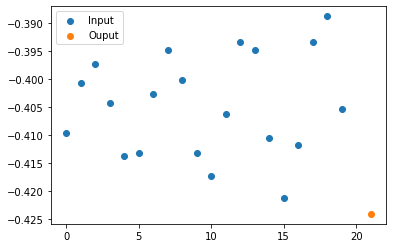

In [9]:
# Numero de instancia que queremos grafiacar
i = 9
largo = len(X_train[i])
# Puntos que vamos a usar como imput
plt.scatter(np.arange(largo),X_train[i], label='Input')
# Output deseado
plt.scatter(largo+1,Y_train[i], label='Ouput')
plt.legend()
plt.show()

#Estoy entrenando mi red para que yo le meto 20 puntos, y mi red me prediga cual va a ser el punto 21.
#Entonces, entreno en mi x_train 20 puntos por instancia, y la respuesta que le doy (y_train) por instancia es justamente el punto 21.

## 2) Redes Neuronales - Regresión

### Modelado

Vamos a definir una red neuronal de la misma forma que lo hicimos anteriormente.

In [10]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(128, input_shape=(look_back,)))                        
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

Las principales diferencias respecto al problema de clasificación son las siguientes:

*   La neurona de salida es una única neurona con activación lineal. Recuerden que ahora buscamos predecir una cantidad, no la probabilidad de pertenencia a una clase.
*   La funcion de costo sera el `mean_squared_error`, ya que queremos minimizar las desviaciones respecto al valor original.



In [11]:
# compiling the sequential model
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Ya podemos entrenar nuestrad red regresora.

In [12]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
47/47 [==============================] - 0s 5ms/step - loss: 0.1362 - mean_absolute_error: 0.2953 - val_loss: 0.1485 - val_mean_absolute_error: 0.3134
Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1225 - mean_absolute_error: 0.2771 - val_loss: 0.1472 - val_mean_absolute_error: 0.3107
Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1123 - mean_absolute_error: 0.2637 - val_loss: 0.1512 - val_mean_absolute_error: 0.3157
Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.1058 - mean_absolute_error: 0.2569 - val_loss: 0.1480 - val_mean_absolute_error: 0.3117
Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0997 - mean_absolute_error: 0.2462 - val_loss: 0.1513 - val_mean_absolute_error: 0.3128
Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.0911 - mean_absolute_error: 0.2342 - val_loss: 0.1538 - val_mean_absolute_error: 0.3142
Epoch 7/10
47/47 [==========

### Analizamos los resultados

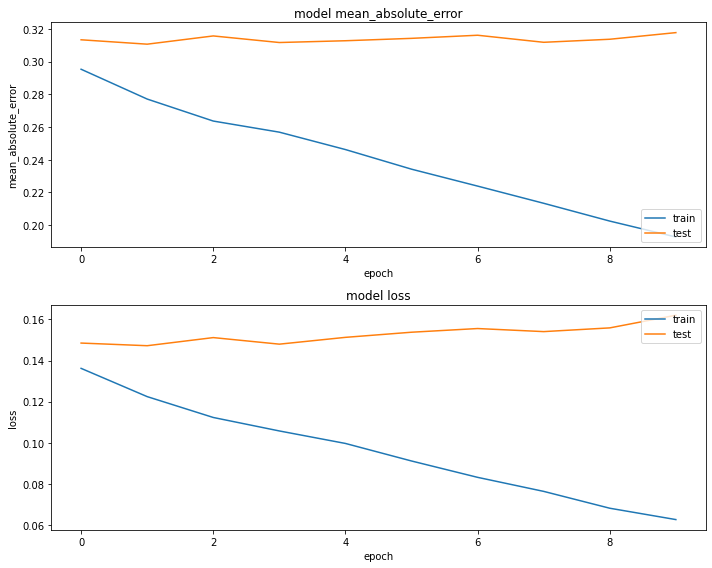

In [13]:
# plotting the metrics
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Los valores de error son bastante bajos en proporcion alos valores de entrada. Comparemos como se ven la parte de la serie temporal del test real vs la predicha por la red.

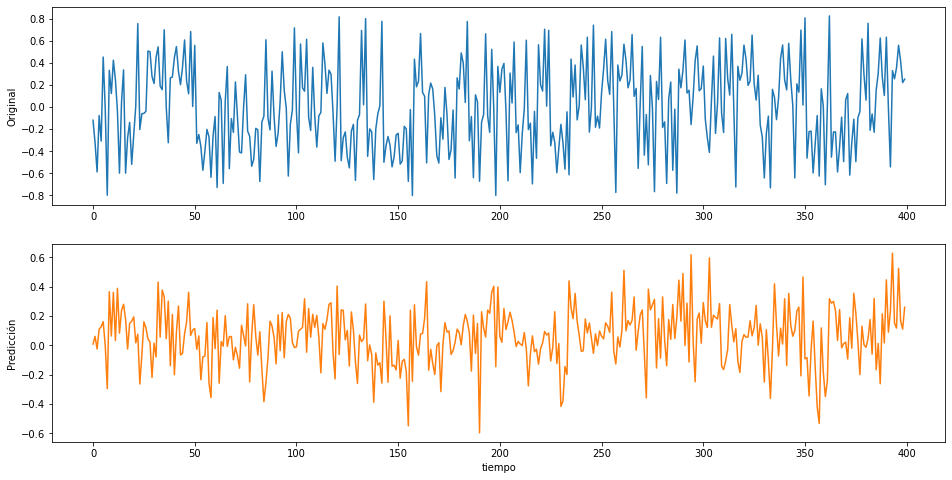

In [14]:
pasos_adelante = 400
Y_test_pred = model.predict(X_test)

fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante])
plt.ylabel('Original')
plt.subplot(2,1,2)
plt.plot(Y_test_pred[0:pasos_adelante],c='C1')
plt.ylabel('Predicción')
plt.xlabel('tiempo')
plt.show()

**Ejercicios:** 


*   Detenerse en este punto y responder la siguiente pregunta: ¿Significa entonces que el modelo de alguna manera capturo la dinámica caótica del sistema? 
No podemos definirlo, ya que cada punto del y_test esta obtenido a partir de 20 puntos originales, obtenidos a partir del sistema dinamico.
*   ¿Como explica que ambas curvas sean tan similares?
La red únicamente esta prediciendo un único punto siguiente, y a cada punto la probabilidad de correcta predicción varía siendo siempre alta.



### Predicción de multiples pasos adelante

La predicción con la cual entrenamos y evaluamos el modelo es para un único paso en el futuro. Es decir estamos siempre prediciendo el siguiente valor de la serie temporal, pero condicionado por los `look_back` pasos anteriores, los cuales se obtuvieron del atractor original. 

Para evaluar una predicción del modelo a largo plazo y poder determinar si la red neuronal efectivamente esta capturando la dinamica de las ecuaciones diferenciales, deberíamos no solo predecir el siguiente paso, sino ver que pasa cuando miramos n pasos hacia adelante.

Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente. Eso es lo que hace el código a continuación:

In [15]:
pasos_adelante = 400

# Tomamos el primer vector del X_test
vec_actual = X_test[0]

# Preparamos una lista vacia que vamos a ir llenando con los valores predichos
lista_valores = []

# Recorremos n pasos hacia adelante
for i in range(pasos_adelante):

    #predecimos el paso siguiente
    nuevo_valor = model.predict(vec_actual.reshape(1,vec_actual.shape[0]))

    # Lo agregamos a la lista
    lista_valores.append(nuevo_valor[0][0])

    # Actualizmaos el vector actual con este paso
    vec_actual = np.roll(vec_actual, -1)
    vec_actual[-1] = nuevo_valor[0][0]

lista_valores = np.asarray(lista_valores)

Ahora si, comparemos este serie temporal predicha por la red con la serie verdadera. Para compararlas, preste atención al tamaño de los máximos y mínimos.

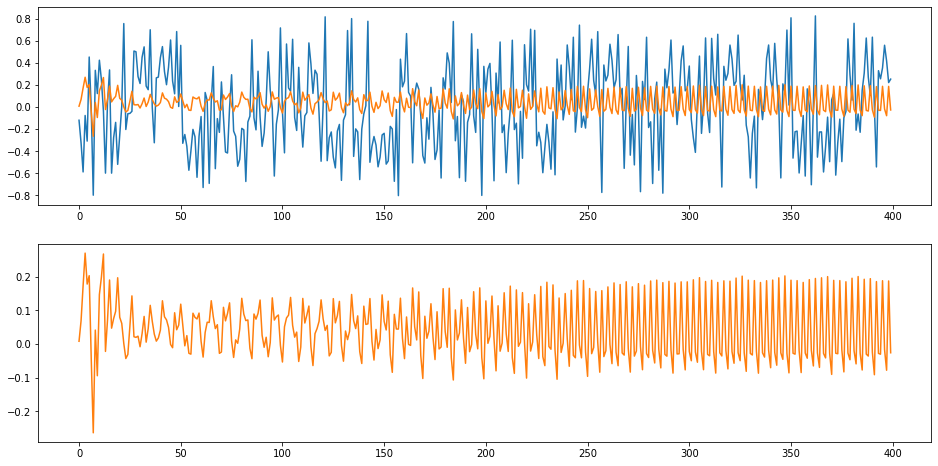

In [16]:
fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante])
plt.plot(lista_valores,c='C1')
plt.subplot(2,1,2)
plt.plot(lista_valores,c='C1')

**Ejercicios:** 

*   ¿Que puede decir de la predicción en este caso? ¿Mejoró o empeoró respecto a la anterior?
La predicción mejoró, pero empeoró la resolución. En estet caso, a diferencia de la anterior, la red va prediciendo los sucesivos puntos, por lo que empieza a predecir sobre su predicción y el error se acumula, la probabilidad de correcta predicción se ve afectado por la probabilidad con la que se predijo correctamente el valor anterior.
*   Vuelva a reproducir los resultados pero esta vez utilizando la variable z del Rossler. Antes de ejecutarlo, piense si espera que le sea mas facil o mas dificil a la red esta tarea.
*   Repita el procedimiento, pero esta vez para un sistema de Lorenz. Modifique el integrador numerico de manera que utilice el metodo rk4 en lugar del de Euler.